# <u>**Coding Challenge 2023 / 2024: Concrete Rules**</u>
### Group (6) Members: Aakash Dharmaraj, Ry Nduma, Felix Watson, Mervyn Ochoa-Dugoy
#### <u>**Overview of the code**</u>

**Pre-processing (to follow-up):**

We implemented a class called **PreProcessing**, which include functions such as FillNaN and Transform. For FillNaN, we used the <u>KNNInputer function from sklearn.impute module</u> to replace all missing (NaN) values from each variable by using the algorithm to find the best appropriate number according to the nearest neighbours of a given data point. The effect on the data were visualised using distribution plots and scatter graphs to observe the trends. These observations were used to then apply <u>appropriate transformations</u> (e.g. Logarithmic) such that each variable showed the best possible linear relationship with the compressive strength, the output variable. 

To ensure the best linear relationship, a skewness score is implemented to check how well distributed the variable data is, which you can find more about here: https://pyshark.com/skewness-in-python/. This is useful as normality plays a crucial role in the performance of our regression models later on.

**Regression Model**

Prior to performing the regression models, we split the data into training and test sets using the <u>train_test_split function from sklearn.model.selection</u>. Using a class called **RegressionModel**, we compare cross validation scores using heatmaps to find suitable parameters (or hyperparameters) for each regression method. These optimised parameters are visualised in plots and error analysis and thus we can find a rational regression method, as well as other practical considerations. By using this regression method, <u>we can obtain the coefficients</u> for each input variable for the interactive graph.

**Interactive Graph**

Using the coefficients obtained by the chosen regression method, and using the transformations applied during pre-processing, we plotted an interactive graph that describes the relationships each input variable has with the compressive strength of concrete. Using sliders, you can directly visualise how the mixture affects the final compressive strength.

(*Note*: For each section mentioned above, specific comments are included in cells and markdowns for clarity and your understanding.)

In [8]:
# Run this cell so the rest of the code can work!
import warnings
warnings.filterwarnings('ignore') #ignores any warning that appear from libraries, e.g. seaborn.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from matplotlib.widgets import Button, Slider

## **Preprocessing**

In [9]:
filename = 'Concrete_Data_Yeh_final.csv'
# input variables: cement, slag, flyash, water, superplasticizer, coarseaggregate, fineaggregate, age
# output variable: csMPa

class PreProcessing:
    '''The aim of this class is to successfully modify the file given, with the most appropriate preprocessing methods. 
    This includes either replacing or removing the NaN values, and applying relevant transformations to the data.'''
    def __init__(self, file):
        self.data = pd.read_csv(file)
        
    def checkNaN (self):
        # To check the number of NaN values from each variable.
        return self.data.isnull().sum()
    
    def FillNaN(self, method='mean') -> pd.DataFrame:
        # Fills each variables missing values with specified method and applies transformations.
        if method == 'mean':
            for variable in self.data.columns[:-1]:
                self.data[variable].fillna(self.data[variable].mean(), inplace = True)
        
        elif method == 'median':
            for variable in self.data.columns[:-1]:
                self.data[variable].fillna(self.data[variable].median(), inplace = True)
        
        elif method == 'knn':
            data = self.data.values
            # split into input and output elements
            ix = [i for i in range(data.shape[1]) if i != 8]
            X, y = data[:, ix], data[:, 8]
            # print total missing
            print('Total Data Values Missing: %d' % sum(np.isnan(X).flatten()))
            # define imputer
            imputer = KNNImputer()
            # fit on the dataset
            imputer.fit(X)
            # transform the dataset
            Xtrans = imputer.transform(X)
            # print total missing
            print('Total Data Values Missing after imputing KNN: %d' % sum(np.isnan(Xtrans).flatten()))
            df= pd.DataFrame(Xtrans)
            df.insert(len(df.columns), 'csMPa', y)
            df.columns = self.data.columns
            self.data = df
        
        else:
            raise ValueError("Invalid imputation method.")
        
        return self.data
    
    def RemoveNaN (self) -> pd.DataFrame:
        # Removes any row that contains any NaN values from the original dataset, use if necessary.
        return self.data.dropna(inplace = True)
    
    def Transform (self) -> pd.DataFrame:
        # Applies relevant transformations to the data for specified columns for optimisation in regression, given FillNaN is used.
        '''Note: This is still to be optimised, keep adjusting this function to see if it improves the model.'''
        trandata = self.FillNaN()
        trandata['cement'] = trandata['cement'].apply(lambda x: np.sqrt(x))
        trandata['slag'] = trandata['slag'].apply(lambda x:np.log(x+1))
        trandata['superplasticizer'] = trandata['superplasticizer'].apply(lambda x: np.sqrt(x**(4/3)))
        trandata['age'] = np.exp(1-(28/trandata['age']))
    
        #trandata['flyash'] = trandata['flyash'].apply(lambda x:np.log(x+1))
        #trandata['water'] = trandata['water'].apply(lambda x: 1/np.sqrt(x))
        #trandata['coarseaggregate'] = trandata['coarseaggregate'].apply(lambda x: x**2)
        #trandata['fineaggregate'] = trandata['fineaggregate'].apply(lambda x: x**2)
        return trandata

checkNaNs = PreProcessing(filename).checkNaN()
print(checkNaNs)

'''For reference, preprocessed: CD = Concrete Data and TCD = Transformed Concrete Data'''
CD = PreProcessing(filename).FillNaN('knn')
CD.describe()

cement               0
slag                 6
flyash               1
water                8
superplasticizer    14
coarseaggregate      7
fineaggregate        3
age                  5
csMPa                0
dtype: int64
Total Data Values Missing: 44
Total Data Values Missing after imputing KNN: 0


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.00000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.847903,54.19866,181.570369,6.215068,972.784699,773.580252,45.428155,35.817961
std,104.506364,86.220315,64.00873,21.271200,5.964942,77.717326,80.159764,62.371898,16.705742
min,102.000000,0.000000,0.00000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.00000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.00000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.30000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.10000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [10]:
TCD = PreProcessing(filename).Transform()
TCD.describe() # General statistics of the data for each variable in the transformed .

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1.030000e+03,1030.000000
mean,16.479268,2.558994,54.122838,181.506262,2.849800,972.653959,773.698150,9.848517e-01,35.817961
std,3.100148,2.407647,63.962458,21.039881,2.398877,77.659130,79.896863,7.399239e-01,16.705742
min,10.099505,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.879529e-12,2.330000
25%,13.869912,0.000000,0.000000,164.900000,0.000000,932.000000,733.250000,4.978707e-02,23.710000
50%,16.519685,3.135494,0.000000,185.000000,3.429095,968.000000,779.300000,1.000000e+00,34.445000
75%,18.708287,4.966335,118.300000,192.000000,4.695575,1029.150000,824.000000,1.648721e+00,46.135000
max,23.237900,5.887215,200.100000,247.000000,10.121322,1145.000000,992.600000,2.517554e+00,82.600000


### *Correlation Matrix*

In [11]:
CD.corr().style.background_gradient(cmap='coolwarm')

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
cement,1.000000,-0.275391,-0.397501,-0.080717,0.090216,-0.108566,-0.222729,0.079688,0.497832
slag,-0.275391,1.000000,-0.323409,0.109913,0.041009,-0.287225,-0.281997,-0.046032,0.133628
flyash,-0.397501,-0.323409,1.000000,-0.258555,0.381479,-0.008929,0.079306,-0.153183,-0.105841
water,-0.080717,0.109913,-0.258555,1.000000,-0.656387,-0.181684,-0.450139,0.274422,-0.291351
superplasticizer,0.090216,0.041009,0.381479,-0.656387,1.000000,-0.263948,0.222991,-0.192707,0.365045
coarseaggregate,-0.108566,-0.287225,-0.008929,-0.181684,-0.263948,1.000000,-0.178383,0.000862,-0.165439
fineaggregate,-0.222729,-0.281997,0.079306,-0.450139,0.222991,-0.178383,1.000000,-0.151734,-0.167119
age,0.079688,-0.046032,-0.153183,0.274422,-0.192707,0.000862,-0.151734,1.000000,0.329289
csMPa,0.497832,0.133628,-0.105841,-0.291351,0.365045,-0.165439,-0.167119,0.329289,1.000000


### *Scaling the Data*
We scale all input variables here so that they are more comparable with each other and suitable for regression later on.

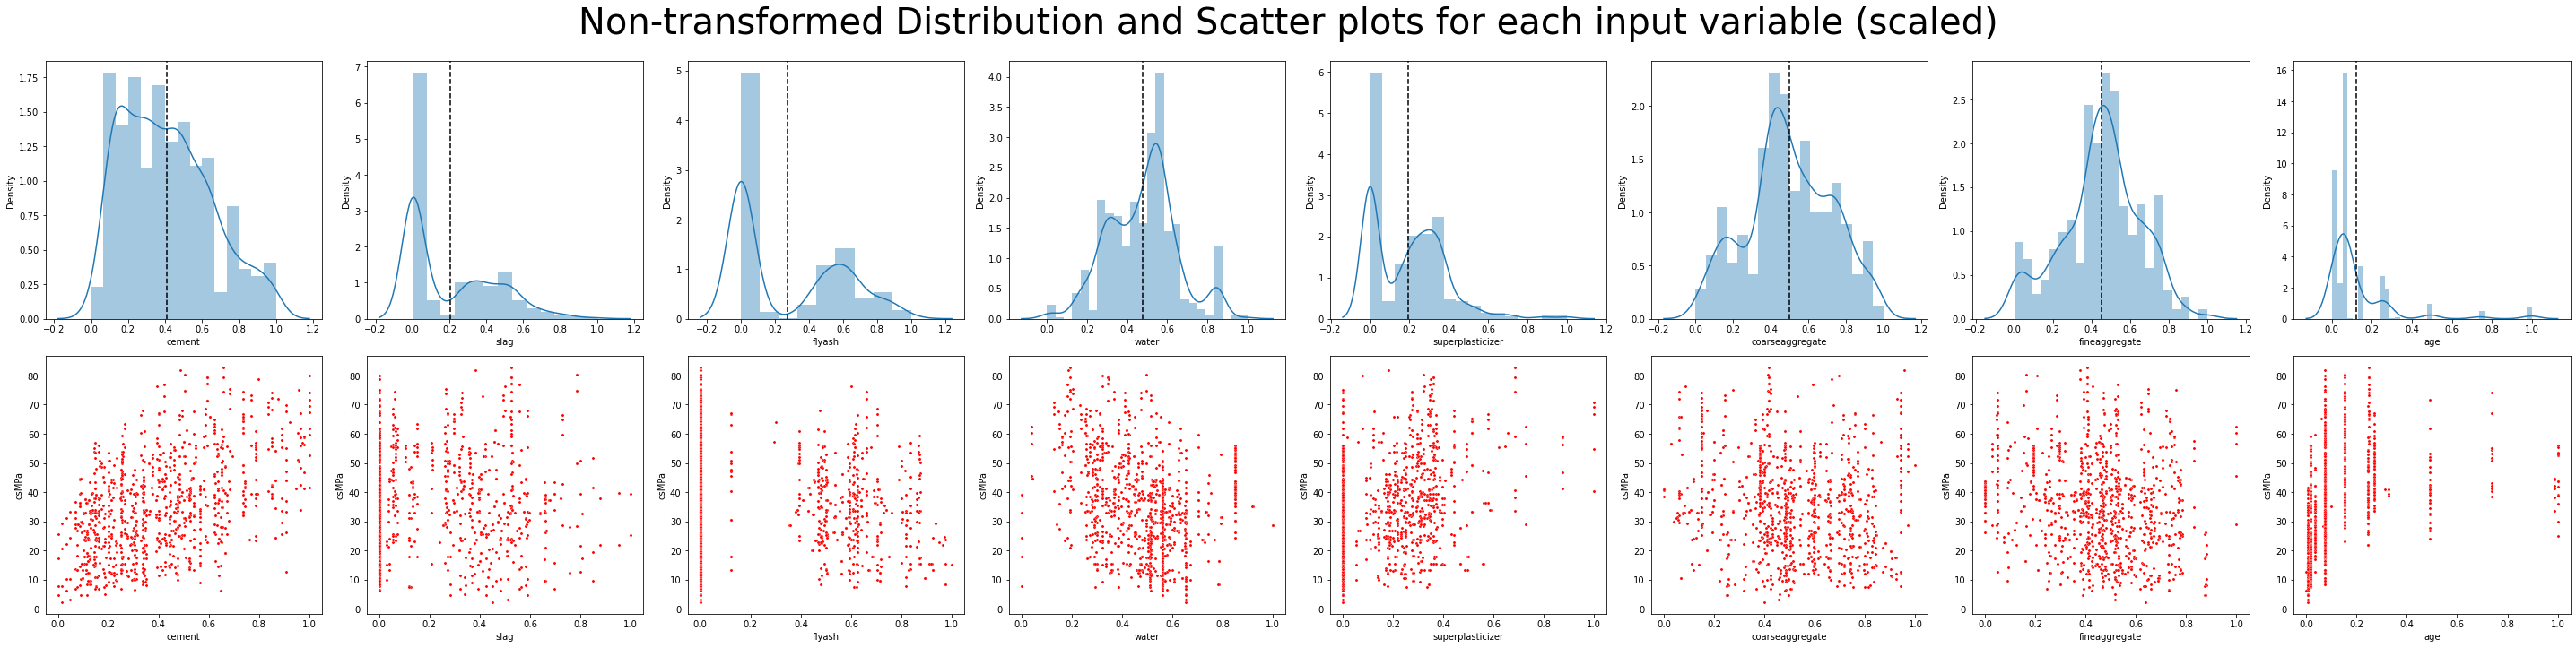

Non-transformed skewness data
            Variable  Skewness
0            cement  0.508739
1              slag  0.800379
2            flyash  0.536419
3             water  0.077448
4  superplasticizer  0.898003
5   coarseaggregate -0.036001
6     fineaggregate -0.253097
7               age  3.273802


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.409059,0.205476,0.270858,0.477399,0.193015,0.499374,0.450527,0.122055,35.817961
std,0.238599,0.239901,0.319884,0.169898,0.185247,0.225922,0.201103,0.171351,16.705742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.330000
25%,0.206336,0.000000,0.000000,0.344249,0.000000,0.380814,0.343578,0.016484,23.710000
50%,0.390183,0.061213,0.000000,0.504792,0.198758,0.485465,0.465379,0.074176,34.445000
75%,0.566210,0.397746,0.591204,0.560703,0.316770,0.663953,0.577020,0.151099,46.135000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,82.600000


In [12]:
scaler = MinMaxScaler()
df = {'Variable': [], 'Skewness': []}
CD.iloc[:,:-1] = scaler.fit_transform(CD.iloc[:,:-1]) # Scales all input variables

fig, axs = plt.subplots(2, 8, figsize=(40, 10))
fig.suptitle('Non-transformed Distribution and Scatter plots for each input variable (scaled)', y = 1, fontsize = 40)

for i, input in enumerate(CD.columns[:-1]):
    df['Variable'].append(input)
    
    sns.distplot(CD[input], ax=axs[0, i])
    axs[0,i].axvline(CD[input].mean(),linestyle="dashed",label="mean", color='black')
    df['Skewness'].append(skew(CD[input]))

    sns.scatterplot(x=CD[input], y=CD['csMPa'], ax=axs[1, i], color = 'red', s = 10)
    #m,b = np.polyfit(CD[input], CD['csMPa'], 1)
    #axs[1,i].plot(CD[input], m*CD[input] + b, color='black', linestyle= 'dashed')

plt.tight_layout()
plt.show()
# To show the general statistics of the scaled CD data for each variable.
print('Non-transformed skewness data\n', pd.DataFrame(df)) # Evaluates variable skewness.
CD.describe() 

## *Interpreting the pre-processed data*
Looking at all the evidence (correlation matrix, distribution plots, scatter graphs, skewness results and the scaled DataFrame), it was best to proceed with the following variables, including brief reasons.
- **Cement**: Square Root transformation - the distribution plot becomes slightly more gaussian; the frequency of cement values below the mean.
- **Slag**: Logarithmic transformation - emphasises the frequency of non zero values; the distribution becomes more normalised.
- **Flyash**: <u>REMOVED</u> - was causing multicolinearity with other input variables and has the lowest gradient relationship with compressive strength. The scatter plot supports this as there is a lot of noise in its data.
- **Water**: No transformation - The skewness result was close to zero, signifying near-perfect normality of data.
- **Superplasticizer**: Square Root transformation - a strong positive trend occurs at low superplasticizer values; becomes less clear if it continues at higher values.
- **Coarse aggregate**: No transformation - no defined trend was seen, there was a wide spread of data points.
- **Fine aggregate**: No transformation - slight negative correlation with compressive strength and was quite linear as it is.
- **Age**: Logarithmic transformation - a curved increase in strength with a slight plateau seen in scatter plot.

**These transformations are seen in the following code below.**

##### *Extra considerations and clarifications*
1. By applying appropriate transformations to columns (square root, logarithmic and reciprocal), this leads to a more defined distibution plot with the data we have from the document. We can generally observe that the closer these plots are to the normal gaussian distribution, the closer the data is to the ideal linear relationship between the input variable and the compressive strength.

2. A few distribution plots, particularly slag, flyash and superplasticizer, have 2 gaussians. This is due to the high amount of 0 values provided from the document. This would skew the regression fit and not represent a reasonable trend with the compreessive strength.

3. Sknewness values were used because, for linear relationships, it assumes a normalised distribution of data.

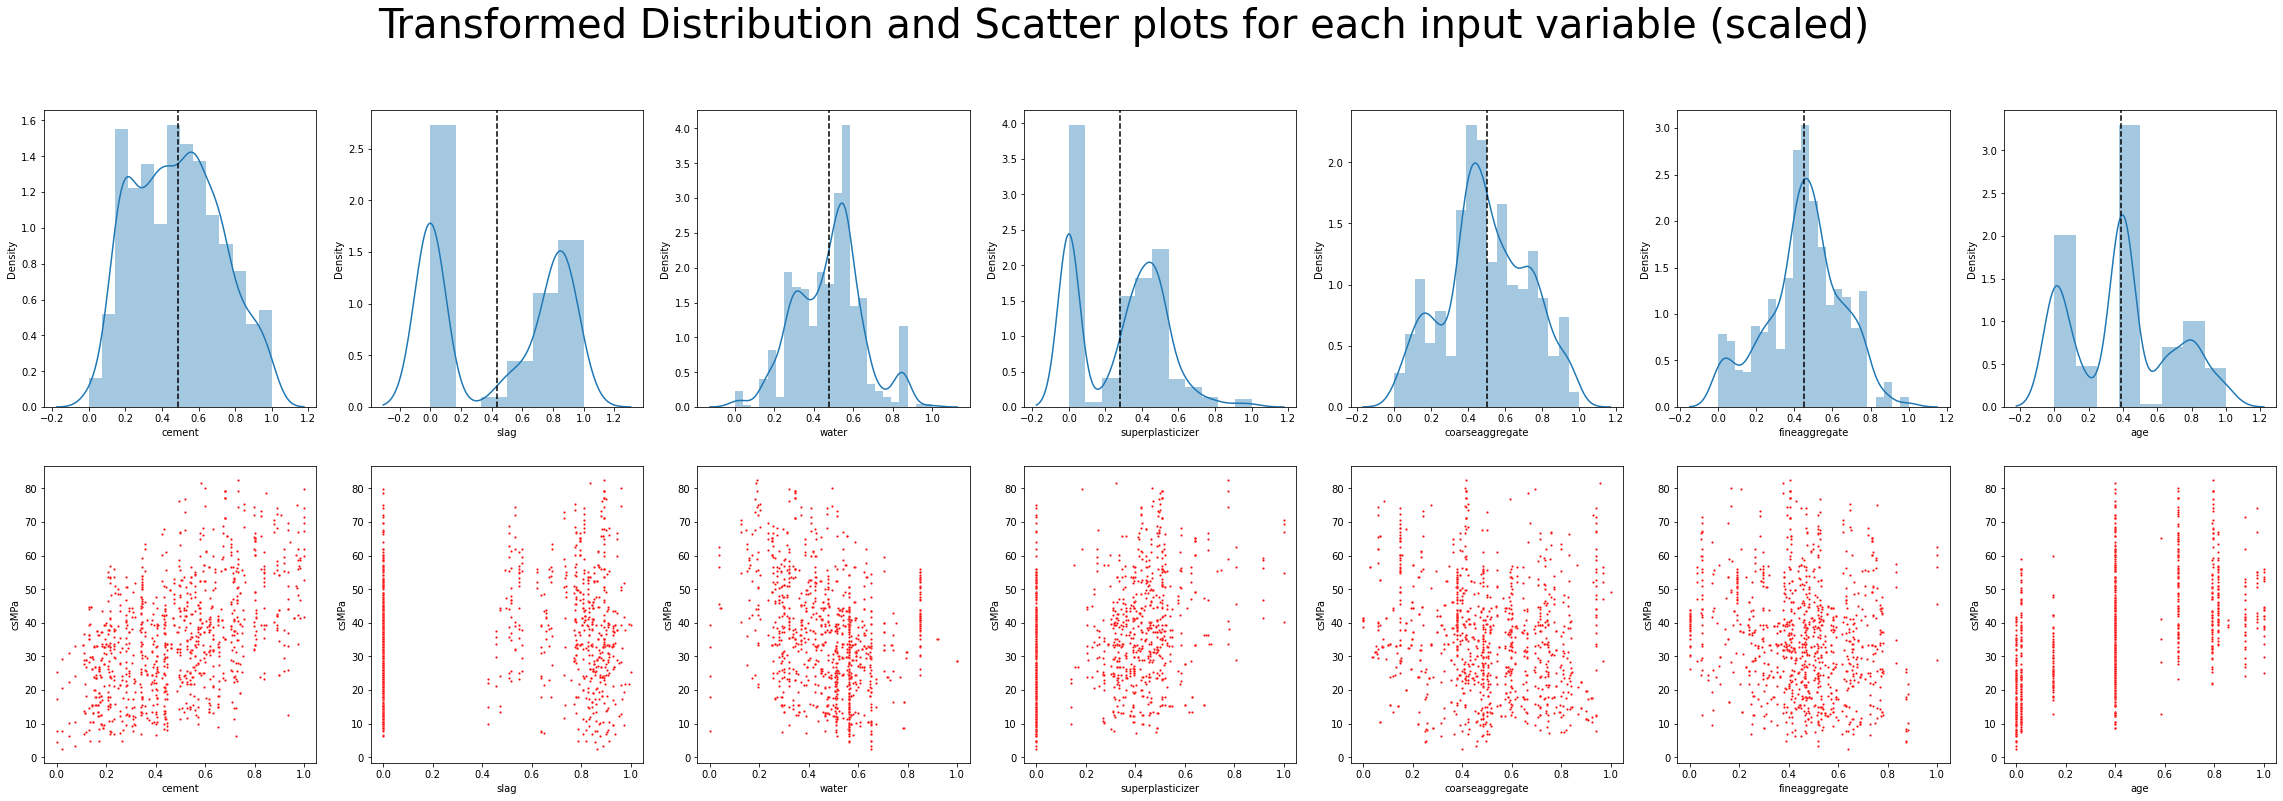

Transformed skewness data
            Variable  Skewness
0            cement  0.189916
1              slag -0.039633
2             water  0.069111
3  superplasticizer  0.106626
4   coarseaggregate -0.032073
5     fineaggregate -0.254057
6               age  0.239808


,cement,slag,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.485582,0.434670,0.476887,0.281564,0.498994,0.450823,0.391194,35.817961
std,0.235961,0.408962,0.168050,0.237012,0.225753,0.200444,0.293906,16.705742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.330000
25%,0.286976,0.000000,0.344249,0.000000,0.380814,0.349348,0.019776,23.710000
50%,0.488658,0.532594,0.504792,0.338799,0.485465,0.464877,0.397211,34.445000
75%,0.655238,0.843580,0.560703,0.463929,0.663227,0.577020,0.654890,46.135000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,82.600000


In [13]:
TCD.iloc[:,:-1] = scaler.fit_transform(TCD.iloc[:,:-1])
TCD.drop('flyash', axis=1, inplace=True)    # Removes the columns that were transformed.

df = {'Variable': [], 'Skewness': []}
fig, axs = plt.subplots(2, (len(TCD.columns)-1), figsize=(40, 12))
fig.suptitle('Transformed Distribution and Scatter plots for each input variable (scaled)', y = 1, fontsize = 40)

for i, input in enumerate(TCD.columns[:-1]):
    df['Variable'].append(input)

    sns.distplot(TCD[input], ax=axs[0, i])
    axs[0,i].axvline(TCD[input].mean(),linestyle="dashed",label="mean", color='black')
    df['Skewness'].append(skew(TCD[input]))

    sns.scatterplot(x=TCD[input], y=TCD['csMPa'], ax=axs[1, i], color = 'red', s = 5)
    #m,b = np.polyfit(TCD[input], TCD['csMPa'], 1)
    #axs[1,i].plot(TCD[input], m*TCD[input] + b, color='black', linestyle= 'dashed')

#plt.tight_layout()
plt.show()

print('Transformed skewness data\n', pd.DataFrame(df))
TCD.describe() # Shows the general statistics of the scaled TCD data for each variable.

# **Regression Model**
The following regression models were considered : Linear, Ridge, Lasso, RandomForest and Support Vector regression (SVR).
- We use test_size = 0.2 to provide the optimal regressions and their scores - this does not deduce which regressions will be excluded.

In [14]:
# Splitting the DataFrame into training and testing sets using sklearn's train_test_split function.
X = TCD.iloc[:,:-1].to_numpy() 
y = TCD['csMPa'].to_numpy()

print(f'y:\n{y}\n')
print(f'X:\n{pd.DataFrame(X)}\n') # Checking the data is split correctly (X = 2D array, y = 1D array).

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y:
[79.99 61.89 40.27 ... 23.7  32.77 32.4 ]

X:
             0         1         2         3         4         5         6
0     1.000000  0.000000  0.321086  0.181994  0.694767  0.205720  0.397211
1     1.000000  0.000000  0.321086  0.181994  0.738372  0.205720  0.397211
2     0.619184  0.843580  0.848243  0.000000  0.380814  0.000000  0.973370
3     0.619184  0.843580  0.848243  0.000000  0.380814  0.000000  0.582948
4     0.303922  0.831183  0.560703  0.000000  0.515698  0.580783  0.998935
...        ...       ...       ...       ...       ...       ...       ...
1025  0.496695  0.808901  0.461661  0.424316  0.200872  0.437280  0.397211
1026  0.597518  0.000000  0.592652  0.470744  0.049128  0.550426  0.397211
1027  0.158813  0.839870  0.566294  0.329850  0.265698  0.466633  0.397211
1028  0.191346  0.889189  0.429712  0.497525  0.548256  0.488961  0.397211
1029  0.460703  0.784761  0.629393  0.414726  0.184593  0.420221  0.397211

[1030 rows x 7 columns]



In [15]:
# Checking the shape of both the training and testing sets are reasonable.
print(y_test.shape, y_train.shape, x_test.shape, x_train.shape)

(206,) (824,) (206, 7) (824, 7)


In [16]:
class RegressionModel:
    '''The aim of this class is to successfully fit the regression model to the training data, predict the y values for the 
    testing data, and evaluate the model using the specified metrics and scores. The regressions can be visualised with plots.'''
    def __init__(self, x_train, x_test, y_train, y_test, regression, **kwargs):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.regression = regression(**kwargs)                  # Initiates regression method with any required arguments.
        self.regfit = self.regression.fit(x_train, y_train)     # Fits the regression method to the training data.
        self.y_pred = self.regression.predict(x_test)           # Predicts the y values for the testing data.
    
    def Metric(self, metriclist) -> pd.DataFrame:
        # Performs error analysis on the given regression model using the specified metrics.
        metricdf = {'Metric': [], 'Score': []}
        for metric in metriclist:
            metricdf['Metric'].append(metric.__name__)
            if metric == cross_val_score:
                # Takes the mean of the cross validation scores using the training data.
                metricdf['Score'].append(metric(self.regression, self.x_train, self.y_train, cv=5).mean())
            else:
                # Takes the metric score for the testing data.
                metricdf['Score'].append(metric(self.y_test, self.y_pred))
        return pd.DataFrame(metricdf)
    
    def RegScores(self) -> pd.Series:
        # Compares the regression model scores between the training and testing data.
        difference = np.abs(self.regression.score(self.x_test, self.y_test) - self.regression.score(self.x_train, self.y_train))
        scores = {'Training Score': self.regression.score(self.x_train, self.y_train), 'Testing Score': self.regression.score(self.x_test, self.y_test), 'Difference': difference.round(4)}
        return pd.Series(scores)

    def Plot(self):
        # Visualises the regression model with the given parameters.
        plt.figure(figsize=(6, 4))
        plt.scatter(self.y_test, self.y_pred, color='red', s=5)
        plt.title(f'{self.regression.__class__.__name__} | Score: {self.regression.score(self.x_test, self.y_test)}')
        plt.plot(y_test,y_test, color='black', linestyle = 'dashed')
        plt.xlabel('Actual csMPa')
        plt.ylabel('Predicted csMPa')
        plt.show()
        return
    
    def Coefficients(self)-> np.ndarray:
        # Returns the coefficients for each input variable of the regression model.
        try:
            if self.regression.__class__.__name__ in ['LinearRegression', 'Ridge', 'Lasso', 'SVR']:
                coeffs = self.regression.coef_
            else:
                coeffs = self.regression.feature_importances_
        except AttributeError:
            coeffs = None
        return coeffs

### *Finding the best parameters / hyperparameters for each model using cross validation*
Note: Please operate RandomForest/SVR heatmaps if needed - these regression models will take longer than usual.

In [17]:
'''Performs the root mean squared error for error analysis when operated.'''
def RMSE(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)
alphas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
metriclist = [RMSE, explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, cross_val_score]

##### <u>Linear Regression</u>

In [18]:
model = RegressionModel(x_train, x_test, y_train, y_test, LinearRegression, normalize = True)
cv1_score = model.Metric(metriclist).loc[model.Metric(metriclist)['Metric'] == 'cross_val_score', 'Score'].values[0]
print(f"Cross validation scores for LinearRegression (normalised): {cv1_score}")

Cross validation scores for LinearRegression (normalised): 0.7760505328891818


##### <u>Ridge and Lasso Regression</u>

Text(69.0, 0.5, 'Alpha')

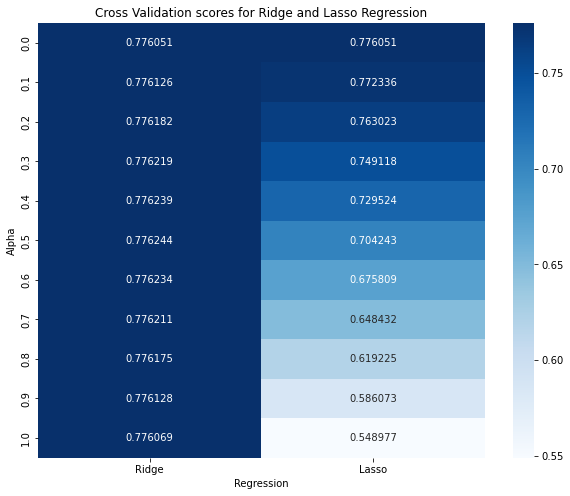

In [19]:
CrossValscores = np.zeros((len(alphas), 2))
for i, regression in enumerate([Ridge, Lasso]):
    for j, alpha in enumerate(alphas):
        if i == 0:
            model = RegressionModel(x_train, x_test, y_train, y_test, regression, alpha = alpha)
        else:
            model = RegressionModel(x_train, x_test, y_train, y_test, regression, alpha = alpha, max_iter = 10000)
        metric_df = model.Metric(metriclist)
        cv_score = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]
        CrossValscores[j][i] = cv_score

# Plotting a heatmap of the cross validation scores for Ridge and Lasso regression.
CrossVal_df = pd.DataFrame(CrossValscores, index=alphas, columns=['Ridge', 'Lasso'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(CrossVal_df, annot=True, fmt=".6f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for Ridge and Lasso Regression')
ax.set_xlabel('Regression')
ax.set_ylabel('Alpha')

##### <u>Random Forest Regression</u>

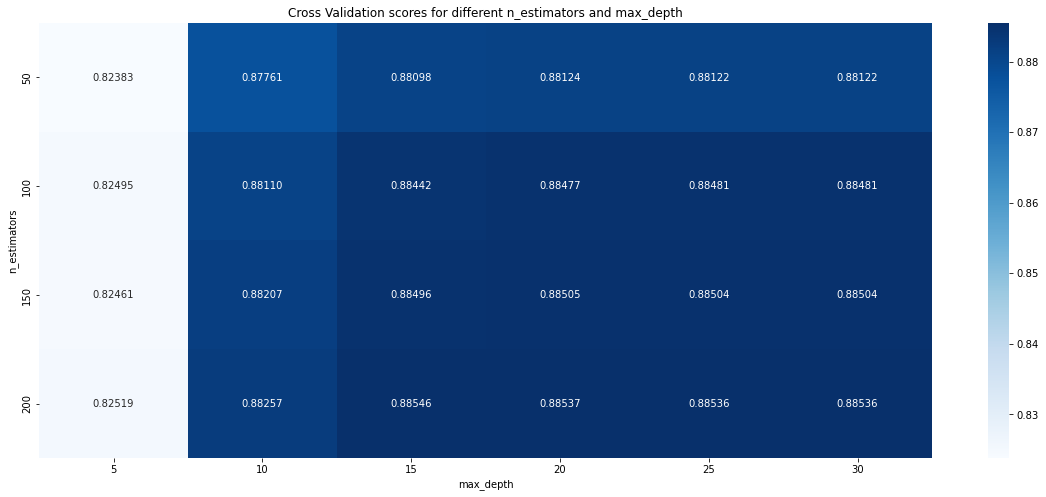

In [20]:
# Only operate if needed - This bit will take longer than usual to run.
RFscore_values = [[0 for _ in range(6)] for _ in range(4)]
for i, n_estimators in enumerate([50,100,150,200]):
    for j, max_depth in enumerate([5,10,15,20,25,30]):
        #print(f'n_estimators = {n_estimators}, max_depth = {max_depth}')
        metric_df = RegressionModel(x_train, x_test, y_train, y_test, RandomForestRegressor, n_estimators = n_estimators, max_depth = max_depth, random_state = 42).Metric(metriclist)
        RFscore_values[i][j] = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]

# Plotting a heatmap of the cross validation scores for different n_estimators and max_depth.
RFscore_df = pd.DataFrame(RFscore_values, index=[50,100,150,200], columns=[5,10,15,20,25,30])
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(RFscore_df, annot=True, fmt=".5f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for different n_estimators and max_depth')
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
plt.show()

##### <u>Support Vector Regression</u>

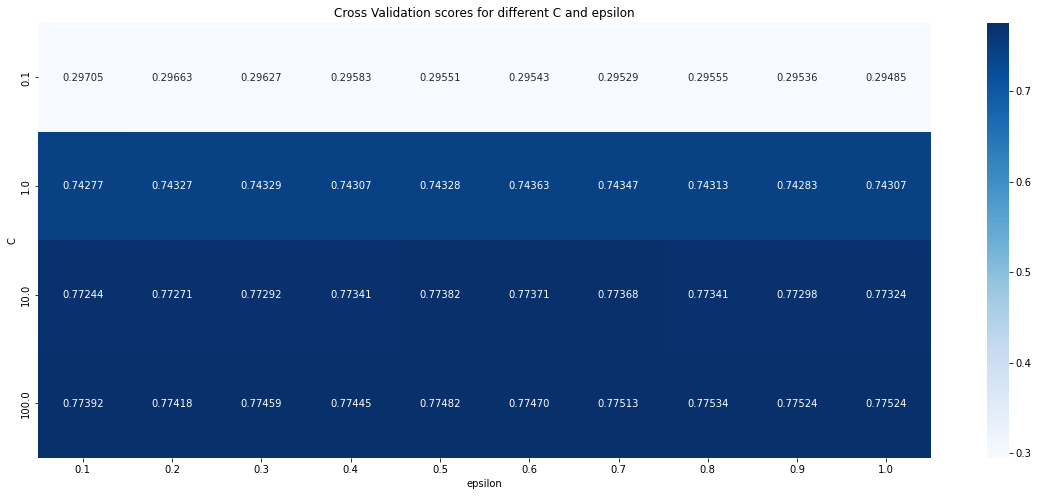

In [21]:
# Only operate if needed - This bit will take longer than usual to run.
SVRscore_values = np.zeros((4,10)) #2D array
for i, c in enumerate([0.1, 1, 10, 100]):
    for j, epsilon in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        #print(f'n_estimators = {n_estimators}, max_depth = {max_depth}')
        metric_df = RegressionModel(x_train, x_test, y_train, y_test, SVR, kernel = 'linear', C = c, epsilon = epsilon).Metric(metriclist) 
        SVRscore_values[i][j] = metric_df.loc[metric_df['Metric'] == 'cross_val_score', 'Score'].values[0]

# Plotting a heatmap of the cross validation scores for different C and epsilon.
SVRscore_df = pd.DataFrame(SVRscore_values, index=[0.1, 1, 10, 100], columns=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(SVRscore_df, annot=True, fmt=".5f", cmap='Blues', ax = ax)
ax.set_title('Cross Validation scores for different C and epsilon')
ax.set_xlabel('epsilon')
ax.set_ylabel('C')
plt.show()

#### <u>**Observations**</u>
For Lasso Regression, the best cross validation score was when alpha = 0, this does not need to be considered anymore because behaves exactly like LinearRegression. Here are the best parameters from each remaining regression:
- Linear: N/A
- Ridge: alpha = 0.5
- RandomForest: n_estimators = 200, max_depth = 15
- SVR: C = 100, epsilon = 0.8

### *Plotting the models with the best parameters*

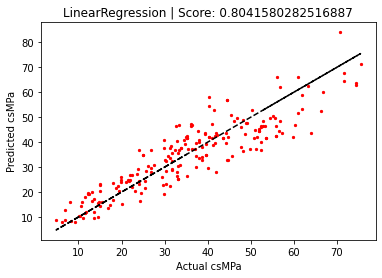

Training Score    0.782244
Testing Score     0.804158
Difference        0.021900
dtype: float64
                     Metric      Score
0                      RMSE   7.103798
1        mean_squared_error  50.463951
2                  r2_score   0.804158
3       mean_absolute_error   5.750081
4  explained_variance_score   0.805120
5           cross_val_score   0.776051


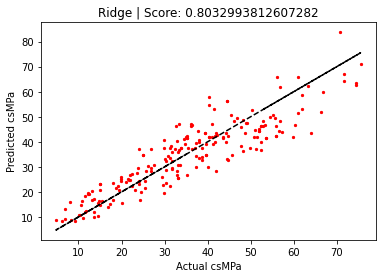

Training Score    0.782114
Testing Score     0.803299
Difference        0.021200
dtype: float64
                     Metric      Score
0                      RMSE   7.119354
1        mean_squared_error  50.685205
2                  r2_score   0.803299
3       mean_absolute_error   5.771346
4  explained_variance_score   0.804261
5           cross_val_score   0.776244


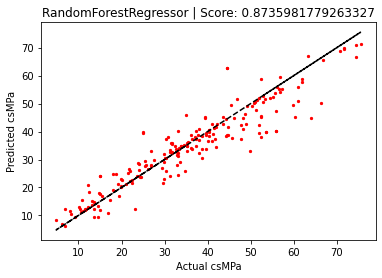

Training Score    0.983557
Testing Score     0.873598
Difference        0.110000
dtype: float64
                     Metric      Score
0                      RMSE   5.707086
1        mean_squared_error  32.570829
2                  r2_score   0.873598
3       mean_absolute_error   3.930452
4  explained_variance_score   0.876351
5           cross_val_score   0.885465


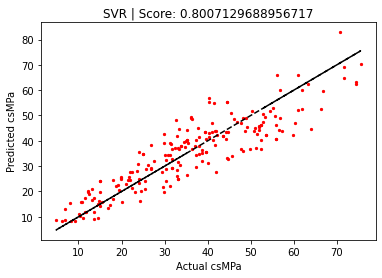

Training Score    0.779029
Testing Score     0.800713
Difference        0.021700
dtype: float64
                     Metric      Score
0                      RMSE   7.166007
1        mean_squared_error  51.351663
2                  r2_score   0.800713
3       mean_absolute_error   5.763774
4  explained_variance_score   0.801073
5           cross_val_score   0.775340


In [22]:
regressors = [LinearRegression, Ridge, RandomForestRegressor, SVR]
metriclist = [RMSE, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, cross_val_score]

for r in regressors:
    if r is LinearRegression:
        model = RegressionModel(x_train, x_test, y_train, y_test, r)
    elif r is Ridge:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, alpha = 0.5, random_state = 42)
    elif r is RandomForestRegressor:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, n_estimators = 200, max_depth = 15, random_state = 42)
    else:
        model = RegressionModel(x_train, x_test, y_train, y_test, r, kernel = 'linear', C = 100, epsilon = 0.8)
    model.Plot()
    print(model.RegScores())            # To compare the regression model scores for the training and testing data.
    print(model.Metric(metriclist))     # To evaluate the regression model error analysis using the specified metrics.

### <u>**Final Observations from the Regression Models**</u>
With reference to the link below, our model provides a 'Good' score, with predicted scores within 80-90% across all regression models. This means our transformations were decently accurate to what actual relationships are between input variables and the compressive strength - the scores can be increased if we precisely find the right relationships. Particularly for water, fine and coarse aggregate, they could have a complex relationship with compressive strength that we couldn't identify from the CD (concretedata) variable. Below is our interpretation from the models.

<u>Ensemble methods are too complex to help us find coefficients.</u> Given how RandomForest (RF) works, it is **not possible to convert feature importances of each variable to a coefficient** - hence regarded as a 'black box'. Furthermore, a large difference in scores between training and test data means that it would indicate overfitting on the training data. However, because its predictivity the closest to 100%, we will use the feature importances function to determine which variable is the most important contributor to the overall compressive strength.

All predicted models become <u>less accurate</u> for very high values of compressive strength. This is expected because of our transformations resulting in underfitted data and the sensitivity to outliers, especially the variables that are highly skewed.
  
Most reasonable choice of regression: **Standard Vector Regression**

- It outperformed the other simpler regression models with a lower RMSE and higher R squared score.

(**Important**: Changed to Linear regression for following code. If you three could find any reason to support or reject my analysis, add them here.)

Reference link: https://stephenallwright.com/good-accuracy-score/#:~:text=There%20is%20a%20general%20rule%20when%20it%20comes,and%2070%25%20-%20OK%20Below%2060%25%20-%20Poor

### *Finding the most important feature to compressive strength*

In [23]:
'''Using RFRegressorCoeffs and SVRCoeffs as mentioned from above observations.'''
LinearCoeffs = RegressionModel(x_train, x_test, y_train, y_test, LinearRegression).Coefficients()                      # if necessary
#RidgeCoeffs = RegressionModel(x_train, x_test, y_train, y_test, Ridge, alpha = 0.3, random_state = 42).Coefficients()  # if necessary
RFRegressorCoeffs = RegressionModel(x_train, x_test, y_train, y_test, RandomForestRegressor, n_estimators = 200, max_depth = 15, random_state = 42).Coefficients()
SVRCoeffs = RegressionModel(x_train, x_test, y_train, y_test, SVR, kernel = 'linear', C = 100, epsilon = 0.8).Coefficients()

age                 0.337525
cement              0.333092
water               0.132651
slag                0.078400
superplasticizer    0.051712
fineaggregate       0.037497
coarseaggregate     0.029123
dtype: float64


<AxesSubplot:>

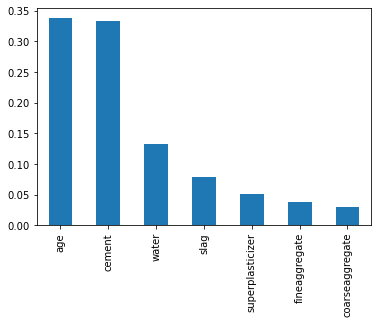

In [24]:
'''Provides the feature importance scores in descending order - a bar graph to help visualise.'''
print(pd.Series(RFRegressorCoeffs, index=TCD.columns[:-1]).sort_values(ascending=False))
pd.Series(RFRegressorCoeffs, index=TCD.columns[:-1]).sort_values(ascending=False).plot(kind='bar', figsize=(6, 4)) # For visualisation.

**Age** is our most important feature that contributes to the compressive strength.

### *Obtaining the coefficients of each variable for the interactive graph*

In [25]:
# Here I used SVR coefficients, but please change this to Linear or Ridge if you find it more appropriate.
#print(pd.Series(SVRCoeffs.ravel(), index=TCD.columns[:-1]))
print(pd.Series(LinearCoeffs, index=TCD.columns[:-1]))
print('\033[1m' + 'Reminder: these coefficients (m) describe a linear relationship between the transformed, \n          scaled feature and the non-transformed, non-scaled compressive strength, i.e. y = mx + b. ' + '\033[0m')

cement              35.280952
slag                11.636904
water              -30.509020
superplasticizer     8.925911
coarseaggregate     -3.256975
fineaggregate       -8.250778
age                 32.891333
dtype: float64
Reminder: these coefficients (m) describe a linear relationship between the transformed, 
          scaled featureand the non-transformed, non-scaled compressive strength, i.e. y = mx + b. 


# **Interactive Graph**
**Function code still needs to be fixed** - please take action on this!

In [26]:
%matplotlib qt
def InteractiveGraph(variable_coeff):
    '''Plots an interactive graph using the coefficients of our chosen regression model, SVR.'''
    def f(cement, slag, water, superplasticizer, coarseaggregate, fineaggregate, age):
        # Using transformations in Preprocessing section.
        y = ((variable_coeff[0]*np.sqrt(cement))
              + (variable_coeff[1]*np.log(slag+1))
                + (variable_coeff[2]*water)
                  + (variable_coeff[3]*np.sqrt(superplasticizer**(4/3)))
                    + (variable_coeff[4]*coarseaggregate)
                      + (variable_coeff[5]*fineaggregate)
                        + (variable_coeff[6]*np.exp(1-28/age))) # Note that flyash is removed. 
        return y
    
    # Create subplot
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.5) 
    ax.set(xlabel='Age', ylabel='Compression Strength (MPa)')

    # Create and plot basic strength against age plot using the mean values of each variable for the initial plot
    t = np.arange(0.1, 365, 1)
    line = f(TCD.mean().iloc[0], TCD.mean().iloc[1], TCD.mean().iloc[2], TCD.mean().iloc[3], TCD.mean().iloc[4], TCD.mean().iloc[5], t)
    l, = plt.plot(t, line)

    #Create reset button to go back to the mean value
    resetax = fig.add_axes([0.025, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', color='0.95', hovercolor='0.7')
    
    #Create sliders for each variable and add them to list Sliders
    def create_Sliders():
        Sliderlist = []
        for i, column in enumerate(TCD.columns[:-2]):
            #plot each slider in a given location, each moving up by 0.5 to get a good spread
            axvariable = plt.axes([0.25, 0.05*(i + 1), 0.65, 0.03])
            var_slider = Slider(axvariable, label = column, valmin = TCD.min().iloc[i], valmax = TCD.max().iloc[i], valinit = TCD.mean().iloc[i])
            #Add each slider to Sliders list for access later
            Sliderlist.append(var_slider)
        return Sliderlist
    
    #Calling the defined function
    Sliders = create_Sliders()

    #The function to be called anytime a slider's value changes which also updates the graph
    def update(val):
        fig.canvas.draw_idle()
        l.set_ydata(f(Sliders[0].val, Sliders[1].val, Sliders[2].val, Sliders[3].val, Sliders[4].val, Sliders[5].val, t))
    
    #Register the update function with each slider
    for i in range(len(TCD.columns[:-2])):
        Sliders[i].on_changed(update)
            
    #This function implements the reset button such that the sliders are brought back to there initial value
    def reset(event):
        for i in range(len(TCD.columns[:-2])):
            Sliders[i].reset()
    button.on_clicked(reset)

    resetax._button = button
    plt.show()
    return

In [27]:
'''To run the Interactive Graph - will open a new tab.'''
w = InteractiveGraph(LinearCoeffs.ravel())
w

*Note*: For high values of age seen in the interactive graph, the predictor becomes less accurate with reasoning mentioned from '<u>Final Observations</u>'.